# Part III: Generate KDEs and obtain persistence diagrams

- Compute the four cardinal directional distance transforms (distance to the closest cell wall along a given cardinal direction) for the cross section.
- Compute a KDE with a grid of stepsize `stepsize`
- Correct KDE boundaries: treat cell walls and nuclei as steep walls.
- Compute sub or superlevel persistence

Notice that the KDE itself is not saved, as it can easily computed again if necessary.
- Saving it would be quite expensive in the long run

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import tifffile as tf
from glob import glob
from scipy import ndimage, stats

from KDEpy import FFTKDE
import gudhi as gd
import json

import utils
from importlib import reload

# Load all general data

- Same setup as in the previous notebooks

Detected 2937 cells
Detected 1365 nuclei


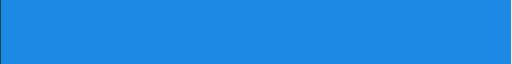

In [2]:
wong = ['#d81b60', '#1e88e5', '#ffc107', '#004d40']
pows2 = 2**np.arange(20) + 1
fs = 15
bw = 25
PP = 6
stepsize = 3
pp = 0
nuclei_mask_cutoff = 1

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
sample = 'D2'

ksrc += sample + os.sep

#wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(tf.imread(wsrc + sample + '_dams.tif').astype(bool), ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col = 0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv', index_col=-1)
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
#cell_nuc.loc[cell_nuc['n_bot'] == 1, 'n_bot'] = 0
#cell_nuc.loc[cell_nuc['n_top'] == 61, 'n_top'] = 65

tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

transcriptomes = np.asarray(metatrans['gene'])
translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
    translocs[i]['cidx'] = label[ translocs[i]['Y'], translocs[i]['X'] ]
    translocs[i]['nidx'] =  lnuc[ translocs[i]['Y'], translocs[i]['X'] ]

tlocs = pd.concat(translocs)

zmax = tlocs['Z'].max()+stepsize
zmin = tlocs['Z'].min()

foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cmap = mpl.colors.ListedColormap(foo)
cmap

In [6]:
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep
isrc += sample + os.sep

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)

if (Cells is None) or (Genes is None):
    print('Make sure that the ID value is an integer')
    print('Or make sure that the specified file exists and is formatted correctly')

# Compute transcript weights for KDE

- If transcript is close to a border (cell wall or nucleus), it becomes heavier to then reflect the Gaussian "weight"
- Inspired from this thread in [crossvalidated](https://stats.stackexchange.com/questions/65866/good-methods-for-density-plots-of-non-negative-variables-in-r/).
- In this case, the weight variability is restrained: it will be at most `2`
- An unaffected transcript will have weight `1` instead.

https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python

In [9]:
if False:
    filename = ksrc + sample + '_border_weights.npy'
    if not os.path.isfile(filename):
        top, right, bottom, left = utils.cardinal_distance_transform(wall)
        wv = stats.norm.cdf(top[tlocs['Y'].values, tlocs['X'].values]+pp, loc=0, scale=bw)
        wv-= stats.norm.cdf(-bottom[tlocs['Y'].values, tlocs['X'].values]-pp, loc=0, scale=bw)
        
        wh = stats.norm.cdf(right[tlocs['Y'].values, tlocs['X'].values]+pp, loc=0, scale=bw) 
        wh-= stats.norm.cdf(-left[tlocs['Y'].values, tlocs['X'].values]-pp, loc=0, scale=bw)
        
        weight = 2-(wv*wh)
        np.save(filename, weight)
    
    weight = np.load(filename, allow_pickle=True)

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/mcarto/figs/D2_GLYMA_05G092200_1749_1748_distance_transform.jpg)

# Select a cell and then a gene

- Get a nice bounding box to just focus on a given cell `cidx`
- A tri-color image `cell` is produced, where
    - `0` is for nuclei and walls
    - `1` for other cytoplasm
    - `2` for the cytosol of the specified cell 
- Produce a regular grid for that box of stepsize `stepsize`
- The grid extends beyond the box by a factor `pad` to account for numerical overflows when the computing KDE
- Get the transcripts of the gene inside that cell

In [7]:
foo = metacell.loc[Cells]
foo[foo['nuclei_area'] > 0 ].sort_values(by='total_area')

,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,number_nuclei,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID,total_volume,cyto_volume,nuclei_volume
ndimage_cellID,,,,,,,,,,,,,,,,,,,
2161,7766,7938,11599,11772,172,173,16978,2003,14975,0.882024,1,7846.62,11671.26,7846.22,11671.09,2162,696098,613975,82123
825,14737,14936,5989,6285,199,296,26017,62,25955,0.997617,0,14837.45,6129.80,14836.97,6129.56,826,1066697,1066697,0
787,5365,5572,5813,6054,207,241,26818,2139,24679,0.920240,1,5479.55,5936.68,5478.83,5936.20,788,1099538,1011839,87699
1207,3412,3627,7589,7801,215,212,29045,3550,25495,0.877776,1,3516.59,7701.65,3516.06,7701.16,1207,1190845,1045295,145550
1454,4379,4596,8638,8885,217,247,29930,1327,28603,0.955663,1,4484.10,8748.03,4483.63,8747.71,1455,1227130,1172723,54407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,5196,5683,9732,10634,487,902,209726,6930,202796,0.966957,1,5445.07,10184.86,5444.52,10184.33,1723,8598766,8397796,200970
1701,8133,8687,9634,10281,554,647,214011,969,213042,0.995472,1,8419.83,9949.02,8419.10,9948.79,1702,8774451,8734722,39729
366,6607,7131,3814,4527,524,713,215410,5423,209987,0.974825,1,6864.81,4170.33,6864.35,4169.82,367,8831810,8701658,130152


In [22]:
PP = 6
cidx = Cells[9]

cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, PP=PP, pxbar=True)
s_ = np.s_[ cextent[2]:cextent[3] , cextent[0]:cextent[1] ]
edt = ndimage.distance_transform_edt(label[s_] == cidx)
axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, cell, label[s_], cextent, zmax, stepsize, cell_nuc)

outw = outside_walls.copy().reshape( list(map(len, axes))[::-1], order='F')
zfactor = np.divide(  list(map(len, axes))[::-1][1:] , np.asarray(cell.shape) )
kbins = np.linspace(0, np.max(edt), 27)

cellhist = np.digitize(edt, kbins, right=True)
zoom = ndimage.zoom(cellhist, zfactor, mode='grid-constant', grid_mode=True)
zoom = (~outw)*np.tile(zoom, reps=(len(axes[-1]), 1,1))

peripherality = pd.DataFrame(index=range(1,len(kbins)))
pcount =  ndimage.histogram(zoom, 1, len(kbins)-1, len(kbins)-1)

In [23]:
tidx = Genes[2]
coords = translocs[tidx].loc[ translocs[tidx]['cidx'] == cidx , ['X','Y', 'Z'] ].values.T

kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T).evaluate(grid)
kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(coords)))
kde[outside_walls] = 0
kde = kde/(np.sum(kde)*(stepsize**len(coords)))
kde = kde.reshape( list(map(len, axes))[::-1], order='F')
kmax = kde.max()

In [24]:
peripherality['sum'] = ndimage.sum_labels(kde, zoom, range(1, len(kbins)))
peripherality['mean'] = peripherality['sum'] / pcount
peripherality.head()

,sum,mean
1,0.001488,1.485606e-07
2,0.001896,1.564598e-07
3,0.002243,1.734776e-07
4,0.002192,1.901262e-07
5,0.002091,1.856358e-07


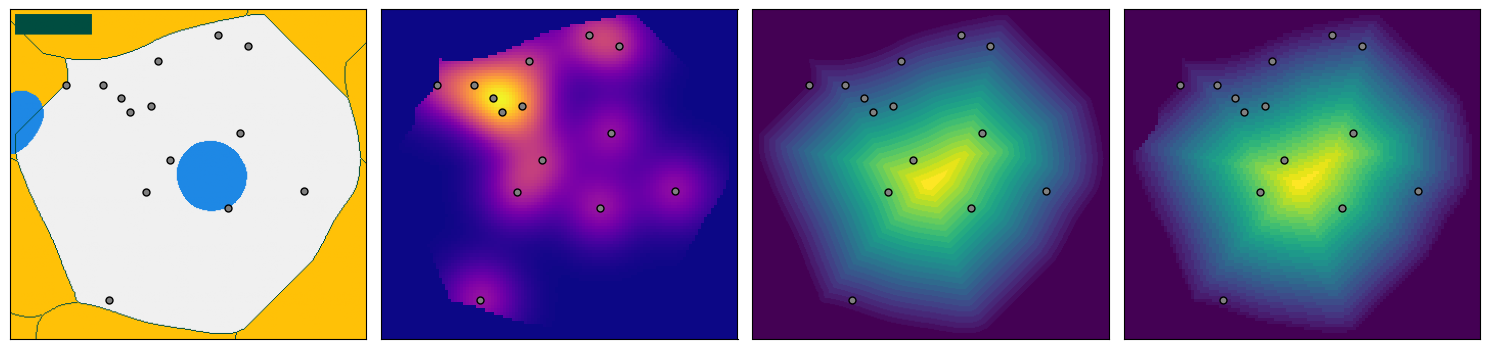

In [27]:
fig, ax = plt.subplots(1,4, figsize=(15,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[0].imshow(cell+1, cmap=cmap, origin='lower', extent=cextent, vmin=0, vmax=nnuc+2);
ax[1].imshow(kde[10], origin='lower', cmap='plasma', vmin=0, vmax=kmax, extent=cextent);
ax[2].imshow(cellhist, origin='lower', cmap='viridis', vmin=0, extent=cextent);
ax[3].imshow(zoom[1], origin='lower', cmap='viridis', vmin=0, extent=cextent);

for j in range(len(ax)):
    ax[j].scatter(coords[0], coords[1], c='gray', marker='o', edgecolor='k', zorder=3, s=25, alpha=1);
    ax[j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax[j].set_aspect('equal')

fig.tight_layout();

# Cubical persistence

- Cubical persistence computed with [`gudhi`](https://gudhi.inria.fr/), which does a decent job whenever images are less than 1000 x 1000 px in size.
- Persistence computed directly on 3D images produced by the KDE
- Played with both sublevel and superlevel filtrations
- Probably we'll stick with superlevel later down the line, as it is intuitively easier to explain and visualize.

In [76]:
for level in levels:
    tdst = '..' + os.sep + level + 'level' + os.sep + sample + os.sep + transcriptomes[tidx] + os.sep
    filename = tdst + transcriptomes[tidx] + '_-_{}_p{}_s{}_bw{}_c{:06d}.json'.format(level,PP,stepsize,bw,cidx)
    if not os.path.isfile(filename):
        cc = gd.CubicalComplex(top_dimensional_cells = utils.get_level_filtration(kde, level) )
        pers = cc.persistence(homology_coeff_field=2, min_persistence=1e-15)
        print(filename)
        with open(filename, 'w') as f:
            json.dump(pers,f)

../sublevel/D2/GLYMA_05G092200/GLYMA_05G092200_-_sub_p6_s3_bw10_c000011.json


FileNotFoundError: [Errno 2] No such file or directory: '../sublevel/D2/GLYMA_05G092200/GLYMA_05G092200_-_sub_p6_s3_bw10_c000011.json'

In [34]:
level = 'sub'
cc = gd.CubicalComplex(top_dimensional_cells = utils.get_level_filtration(kde, level) )
pers = cc.persistence(homology_coeff_field=2, min_persistence=1e-15)

In [41]:
tdst = '..' + os.sep + level + 'level' + os.sep + sample + os.sep + transcriptomes[tidx] + os.sep
filename = tdst + transcriptomes[tidx] + '_-_{}_p{}_s{}_bw{}_c{:06d}.json'.format(level,PP,stepsize,bw,cidx)
print(filename)

../sublevel/D2/GLYMA_12G027400/GLYMA_12G027400_-_sub_p6_s3_bw25_c000810.json


In [35]:
bd = np.zeros((len(pers), 3), dtype=float)
for i in range(len(bd)):
    bd[i, 0] = pers[i][0]
    bd[i, 1:] = pers[i][1]
bd[ bd == np.inf] = kmax

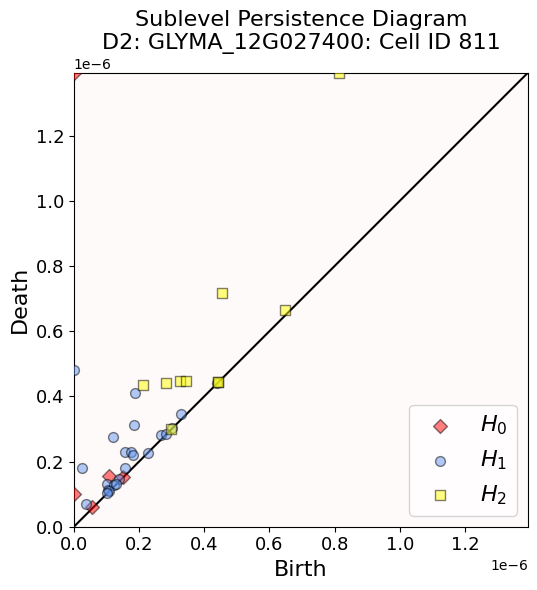

In [36]:
fs = 16; marker = ['D', 'o', 's']; color = ['red','cornflowerblue', 'yellow']
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(bd.shape[1]):
    mask = bd[:,0] == i
    ax[0].scatter(bd[mask, 1], bd[mask, 2], label='$H_{}$'.format(i), marker=marker[i], 
                  c=color[i], s=50, linewidth=1, edgecolor='k', zorder=i+4, alpha=0.5)

ax[0].scatter([0, np.max(bd[:,1:])] , [np.max(bd[:,1:]), np.max(bd[:,1:])] , alpha=0)
ax[0].legend(loc='lower right', fontsize=fs)
ax[0].set_aspect(1)
ax[0].axline(xy1=(0,0), slope=1, c='k', zorder=1)
ax[0].tick_params(labelsize=fs-3)
ax[0].set_xlabel('Birth', fontsize=fs)
ax[0].set_ylabel('Death', fontsize=fs)
ax[0].margins(0)
ax[0].set_facecolor('snow')

title = '{}level Persistence Diagram\n{}: {}: Cell ID {}'.format(level.title(), sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'])
ax[0].set_title(title, fontsize=fs)

fig.tight_layout()

In [40]:
print(coords.shape)
bd[bd[:,0] == 2].shape

(3, 14)


(10, 3)

# What if we just want to focus on a subset of cells and genes?

In [278]:
glob('..' + os.sep + '*level' + os.sep + sample + os.sep + transcriptomes[tidx] + os.sep + '*c{:06d}.json'.format(cidx))

['../suplevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sup_p6_s3_bw30_c000800.json',
 '../suplevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sup_p6_s3_bw10_c000800.json',
 '../suplevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sup_p6_s3_bw15_c000800.json',
 '../suplevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sup_p6_s3_bw20_c000800.json',
 '../suplevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sup_p6_s3_bw25_c000800.json',
 '../sublevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sub_p6_s3_bw30_c000800.json',
 '../sublevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sub_p6_s3_bw25_c000800.json',
 '../sublevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sub_p6_s3_bw20_c000800.json',
 '../sublevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sub_p6_s3_bw10_c000800.json',
 '../sublevel/D2/GLYMA_17G195900/GLYMA_17G195900_-_sub_p6_s3_bw15_c000800.json']